Created on Thu Apr 18 05:43:21 2024

@author: Santiago D'hers

Use:

- This script will compare the performance of different trained models

Requirements:

- Models trained with 3a-Create_Models.py
- Access to the file colabeled_data.csv, where we can find:
    - Position and labels for representative exploration events
    - It includes the labels of 5 viewers (so far)

In [1]:
import h5py
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import datetime

import joblib

# from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, classification_report, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.models import load_model

import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

print(tf.config.list_physical_devices('GPU'))

[]


In [2]:
desktop = 'C:/Users/dhers/Desktop'
STORM_folder = os.path.join(desktop, 'STORM/models')

colabels_file = os.path.join(STORM_folder, 'colabeled_data.csv')
colabels = pd.read_csv(colabels_file)

before = 2
after = 2

frames = before + after + 1

today = datetime.datetime.now()
# use_model_date = today.date()
use_model_date = '2024-10-13'

In [3]:
def median_filter(df, window_size = 3):
    if window_size % 2 == 0:
        raise ValueError("Window size must be odd")
    
    # Apply the median filter
    filtered_df = df.apply(lambda x: x.rolling(window=window_size, center=True).median())
    
    # Fill NaN values with the original values
    filtered_df = filtered_df.combine_first(df)
    
    # Count the number of changed values
    changed_values_count = (df != filtered_df).sum().sum()
    
    # Print the count of changed values
    print(f"Median filter changed {changed_values_count} points")
    
    return filtered_df

def sigmoid(x, k=20):
    return 1 / (1 + np.exp(-k * (x - 0.2) + (k/2)))

In [4]:
def rescale(df, obj_cols = 4, body_cols = 16, labels = True, focus = True):
    
    # First for the object on the left
    # Select columns 5 to 16 (bodyparts)
    left_df = df.iloc[:, obj_cols:body_cols].copy()
    
    # Calculate the offsets for x and y coordinates for each row
    x_left = df.iloc[:, 0].copy()  # Assuming x-coordinate is in the first column
    y_left = df.iloc[:, 1].copy()  # Assuming y-coordinate is in the second column

    # Subtract the offsets from all values in the appropriate columns
    for col in range(0, left_df.shape[1]):
        if col % 2 == 0:  # Even columns
            left_df.iloc[:, col] -= x_left
        else:  # Odd columns
            left_df.iloc[:, col] -= y_left
    
    # Now for the object on the right
    # Select columns 5 to 16 (bodyparts)
    right_df = df.iloc[:, obj_cols:body_cols].copy()
    
    # Calculate the offsets for x and y coordinates for each row
    x_right = df.iloc[:, 2].copy()  # Assuming x-coordinate is in the first column
    y_right = df.iloc[:, 3].copy()  # Assuming y-coordinate is in the second column

    # Subtract the offsets from all values in the appropriate columns
    for col in range(0, right_df.shape[1]):
        if col % 2 == 0:  # Even columns
            right_df.iloc[:, col] -= x_right
        else:  # Odd columns
            right_df.iloc[:, col] -= y_right
    
    if labels:
        left_df['Labels'] = df.iloc[:, -2].copy()
        right_df['Labels'] = df.iloc[:, -1].copy()
    
    final_df = pd.concat([left_df, right_df], ignore_index=True)
    
    if labels:
        if focus:
            final_df = focus_rows(final_df)
        # Pop the last column and store it in 'labels'
        labels = final_df.pop(final_df.columns[-1])
    
        return final_df, labels
    
    return final_df

In [11]:
def reshape(data, labels, back, forward):
        
    if isinstance(data, pd.DataFrame):
        data = data.to_numpy()
    reshaped_data = []
    
    if labels is not False:
        if isinstance(labels, pd.DataFrame):
            labels = labels.to_numpy()
        reshaped_labels = []
        
    for i in range(0, back):
        reshaped_data.append(data[: 1 + back + forward])
        if labels is not False:
            reshaped_labels.append(labels[0])
            
    for i in range(back, len(data) - forward):
        reshaped_data.append(data[i - back : 1 + i + forward])
        if labels is not False:
            reshaped_labels.append(labels[i])
    
    for i in range(len(data) - forward, len(data)):
        reshaped_data.append(data[-(1 + back + forward):])
        if labels is not False:
            reshaped_labels.append(labels[i])
    
    reshaped_data_tf = tf.convert_to_tensor(reshaped_data, dtype=tf.float64)
    
    if labels is not False:
        reshaped_labels_tf = tf.convert_to_tensor(reshaped_labels, dtype=tf.float64)
    
        return reshaped_data_tf, reshaped_labels_tf
    
    return reshaped_data_tf

In [20]:
# Load the data

# The mouse position is on the first 22 columns of the csv file
position = colabels.iloc[:, :16].copy() # We leave out the tail

tail = colabels.iloc[:, 16:22].copy()

# The labels for left and right exploration are on the rest of the columns, we need to extract them
lblr_A = colabels.iloc[:, 22:24].copy()
lblr_A = median_filter(lblr_A, window_size = 5)

lblr_B = colabels.iloc[:, 24:26].copy()
lblr_B = median_filter(lblr_B, window_size = 5)

lblr_C = colabels.iloc[:, 26:28].copy()
lblr_C = median_filter(lblr_C, window_size = 5)

lblr_D = colabels.iloc[:, 28:30].copy()
lblr_D = median_filter(lblr_D, window_size = 5)

lblr_E = colabels.iloc[:, 30:32].copy()
lblr_E = median_filter(lblr_E, window_size = 5)

geometric = colabels.iloc[:, 32:34].copy() # We dont use the geometric labels to train the model
geometric = median_filter(geometric, window_size = 5)
geometric.columns = ['Left', 'Right']

dfs = [lblr_A, lblr_B, lblr_C, lblr_D, lblr_E]

Median filter changed 39 points
Median filter changed 0 points
Median filter changed 59 points
Median filter changed 34 points
Median filter changed 22 points
Median filter changed 156 points


In [21]:
# Calculate average labels
sum_df = pd.DataFrame()
for df in dfs:
    df.columns = ['Left', 'Right']
    sum_df = sum_df.add(df, fill_value=0)
avrg = sum_df / len(dfs)

# Transform values using sigmoid function
avrg_sigmoid = round(sigmoid(avrg),2)  # Adjust k as needed
avrg_filtered = median_filter(avrg_sigmoid, window_size = 5)

Median filter changed 33 points


In [22]:
# Load the saved models
model_simple = load_model(os.path.join(STORM_folder, f'simple/model_simple_{use_model_date}.keras'))
model_wide = load_model(os.path.join(STORM_folder, f'wide/model_wide_{use_model_date}.keras'))
RF_model = joblib.load(os.path.join(STORM_folder, f'RF/model_RF_{use_model_date}.pkl'))

In [23]:
def use_model(position, model, rescaling = True, reshaping = False):
    
    if rescaling:
        df = rescale(position, labels = False)
    
    if reshaping:
        df = reshape(df, False, before, after)
    
    pred = model.predict(df)
    
    pred = pred.flatten()
    
    # Determine the midpoint
    midpoint = len(pred) // 2
    
    # Split the array into two halves
    left = pred[:midpoint]
    right = pred[midpoint:]
    
    # Create a new DataFrame with the two halves as separate columns
    labels = pd.DataFrame({
        'Left': left,
        'Right': right
    })
    
    labels = median_filter(labels.round(2))
    
    return labels

In [24]:
X_all = position.copy()

all_simple = use_model(X_all, model_simple)
all_simple_binary = (all_simple > 0.5).astype(int) 

all_wide = use_model(X_all, model_wide, reshaping = True)
all_wide_binary = (all_wide > 0.5).astype(int)

all_RF = use_model(X_all, RF_model)

5220/5220 ━━━━━━━━━━━━━━━━━━━━ 3s 498us/step
Median filter changed 706 points
5220/5220 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
Median filter changed 340 points
Median filter changed 42 points


In [25]:
avrg_binary = (avrg_filtered > 0.5).astype(int)

In [26]:
labelers = [all_simple_binary, all_wide_binary, all_RF, lblr_A, lblr_B, lblr_C, lblr_D, lblr_E, geometric]
labelers_names = ['simple', 'wide', 'RF', 'lblr_A', 'lblr_B', 'lblr_C', 'lblr_D', 'lblr_E', 'geometric']

for i, labeler in enumerate(labelers):
    accuracy = accuracy_score(labeler, avrg_binary)
    precision = precision_score(labeler, avrg_binary, average='weighted')
    recall = recall_score(labeler, avrg_binary, average='weighted')
    f1 = f1_score(labeler, avrg_binary, average='weighted')
    
    mse = mean_squared_error(labeler, avrg)
    mae = mean_absolute_error(labeler, avrg)
    r2 = r2_score(labeler, avrg)

    # Print evaluation metrics along with the labeler's name
    print(f"Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Mean Squared Error = {mse:.4f}, Mean Absolute Error = {mae:.4f}, R-squared = {r2:.4f} -> {labelers_names[i]}")

Accuracy = 0.9648, Precision = 0.9326, Recall = 0.7701, F1 Score = 0.8436, Mean Squared Error = 0.0132, Mean Absolute Error = 0.0258, R-squared = 0.7733 -> simple
Accuracy = 0.9478, Precision = 0.8782, Recall = 0.6919, F1 Score = 0.7739, Mean Squared Error = 0.0190, Mean Absolute Error = 0.0317, R-squared = 0.6874 -> wide
Accuracy = 0.9713, Precision = 0.9525, Recall = 0.8027, F1 Score = 0.8712, Mean Squared Error = 0.0128, Mean Absolute Error = 0.0255, R-squared = 0.7760 -> RF
Accuracy = 0.9470, Precision = 0.9973, Recall = 0.6581, F1 Score = 0.7928, Mean Squared Error = 0.0108, Mean Absolute Error = 0.0234, R-squared = 0.8495 -> lblr_A
Accuracy = 0.9709, Precision = 0.7581, Recall = 0.9575, F1 Score = 0.8436, Mean Squared Error = 0.0153, Mean Absolute Error = 0.0279, R-squared = 0.5873 -> lblr_B
Accuracy = 0.9224, Precision = 0.9918, Recall = 0.5674, F1 Score = 0.7219, Mean Squared Error = 0.0178, Mean Absolute Error = 0.0305, R-squared = 0.7804 -> lblr_C
Accuracy = 0.9662, Precision

In [27]:
avrg_1 = (avrg > 0.1).astype(int)
avrg_1 = median_filter(avrg_1)
avrg_2 = (avrg > 0.3).astype(int)
avrg_2 = median_filter(avrg_2)
avrg_3 = (avrg > 0.5).astype(int)
avrg_3 = median_filter(avrg_3)
avrg_4 = (avrg > 0.7).astype(int)
avrg_4 = median_filter(avrg_4)
avrg_5 = (avrg > 0.9).astype(int)
avrg_5 = median_filter(avrg_5)

df = pd.DataFrame()

df["avrg_1"] = avrg_1["Left"] + avrg_1["Right"]
df["avrg_2"] = avrg_2["Left"] + avrg_2["Right"]
df["avrg_3"] = avrg_3["Left"] + avrg_3["Right"]
df["avrg_4"] = avrg_4["Left"] + avrg_4["Right"]
df["avrg_5"] = avrg_5["Left"] + avrg_5["Right"]

df["simple"] = all_simple_binary["Left"] + all_simple_binary["Right"]
df["wide"] = all_wide_binary["Left"] + all_wide_binary["Right"]

df["RF"] = all_RF["Left"] + all_RF["Right"]

df["geometric"] = geometric["Left"] + geometric["Right"]

df["lblr_A"] = lblr_A["Left"] + lblr_A["Right"]
df["lblr_B"] = lblr_B["Left"] + lblr_B["Right"]
df["lblr_C"] = lblr_C["Left"] + lblr_C["Right"]
df["lblr_D"] = lblr_D["Left"] + lblr_D["Right"]
df["lblr_E"] = lblr_E["Left"] + lblr_E["Right"]

Median filter changed 1 points
Median filter changed 5 points
Median filter changed 2 points
Median filter changed 4 points
Median filter changed 3 points



Cosine Similarity:
             avrg_1    avrg_2    avrg_3    avrg_4    avrg_5    simple  \
avrg_1     1.000000  0.867340  0.775815  0.707460  0.584187  0.757643   
avrg_2     0.867340  1.000000  0.895549  0.816977  0.676127  0.845554   
avrg_3     0.775815  0.895549  1.000000  0.912264  0.754986  0.868465   
avrg_4     0.707460  0.816977  0.912264  1.000000  0.827596  0.847743   
avrg_5     0.584187  0.676127  0.754986  0.827596  1.000000  0.716021   
simple     0.757643  0.845554  0.868465  0.847743  0.716021  1.000000   
wide       0.745715  0.810246  0.812551  0.779934  0.665534  0.871609   
RF         0.743137  0.830916  0.874090  0.874866  0.729383  0.909565   
geometric  0.630746  0.717724  0.766421  0.754808  0.681099  0.765226   
lblr_A     0.872794  0.956487  0.879557  0.810522  0.672602  0.840452   
lblr_B     0.626314  0.721406  0.801299  0.846437  0.937094  0.738705   
lblr_C     0.936465  0.900808  0.817140  0.752056  0.626298  0.783724   
lblr_D     0.805108  0.838609  

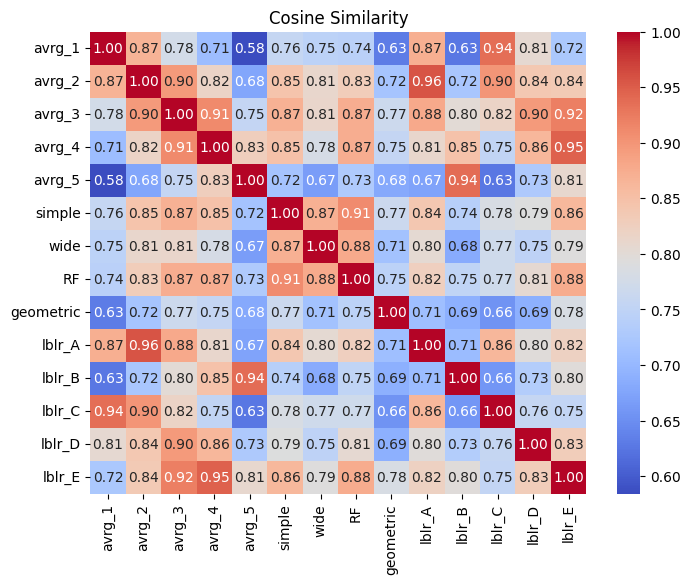

In [30]:
# Compute Cosine similarity

cosine_sim = pd.DataFrame(cosine_similarity(df.T), index=df.columns, columns=df.columns)

print("\nCosine Similarity:")
print(cosine_sim)

#%% Plot Cosine similarity heatmap

plt.figure(figsize=(8, 6))
sns.heatmap(cosine_sim.astype(float), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Cosine Similarity")
plt.show()

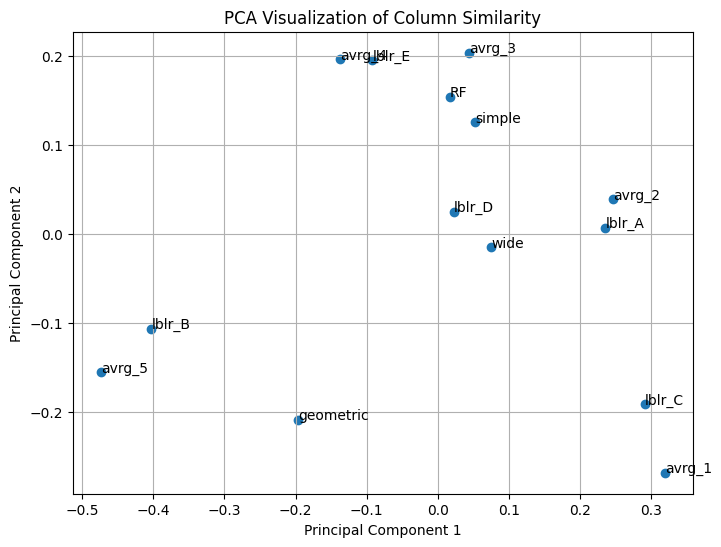

In [32]:
from sklearn.decomposition import PCA

# Use PCA for dimensionality reduction to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(cosine_sim)

# Plot the 2D representation
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1])

# Annotate the points with column names
for i, column in enumerate(df.columns):
    plt.annotate(column, (pca_result[i, 0], pca_result[i, 1]))

plt.title("PCA Visualization of Column Similarity")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

Now we can use the models in an example video

In [33]:
# Prepare the dataset of a video we want to analyze and see

X_view = pd.read_csv(os.path.join(STORM_folder, 'example/Example_position.csv'))
video_path = os.path.join(STORM_folder, 'example/Example_video.mp4')

labels_A = pd.read_csv(os.path.join(STORM_folder, 'example/Example_Marian.csv'), usecols=['Left', 'Right'])
labels_B = pd.read_csv(os.path.join(STORM_folder, 'example/Example_Agus.csv'), usecols=['Left', 'Right'])
labels_C = pd.read_csv(os.path.join(STORM_folder, 'example/Example_Santi.csv'), usecols=['Left', 'Right'])
labels_D = pd.read_csv(os.path.join(STORM_folder, 'example/Example_Guille.csv'), usecols=['Left', 'Right'])
labels_E = pd.read_csv(os.path.join(STORM_folder, 'example/Example_Dhers.csv'), usecols=['Left', 'Right'])

"""
labels_A = smooth_column(labels_A)
labels_B = smooth_column(labels_B)
labels_C = smooth_column(labels_C)
labels_D = smooth_column(labels_D)
labels_E = smooth_column(labels_E)
"""

dfs_example = [labels_A, labels_B, labels_C, labels_D, labels_E]

# Calculate average labels
sum_df_example = pd.DataFrame()
for df in dfs_example:
    sum_df_example = sum_df_example.add(df, fill_value=0)
avrg_example = sum_df_example / len(dfs)

# Transform values using sigmoid function
transformed_avrg_example = round(sigmoid(avrg_example, k=20),2)  # Adjust k as needed

In [34]:
autolabels_simple = use_model(X_view, model_simple)
autolabels_wide = use_model(X_view, model_wide, reshaping = True)
autolabels_RF = use_model(X_view, RF_model)

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
Median filter changed 80 points
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Median filter changed 34 points
Median filter changed 9 points


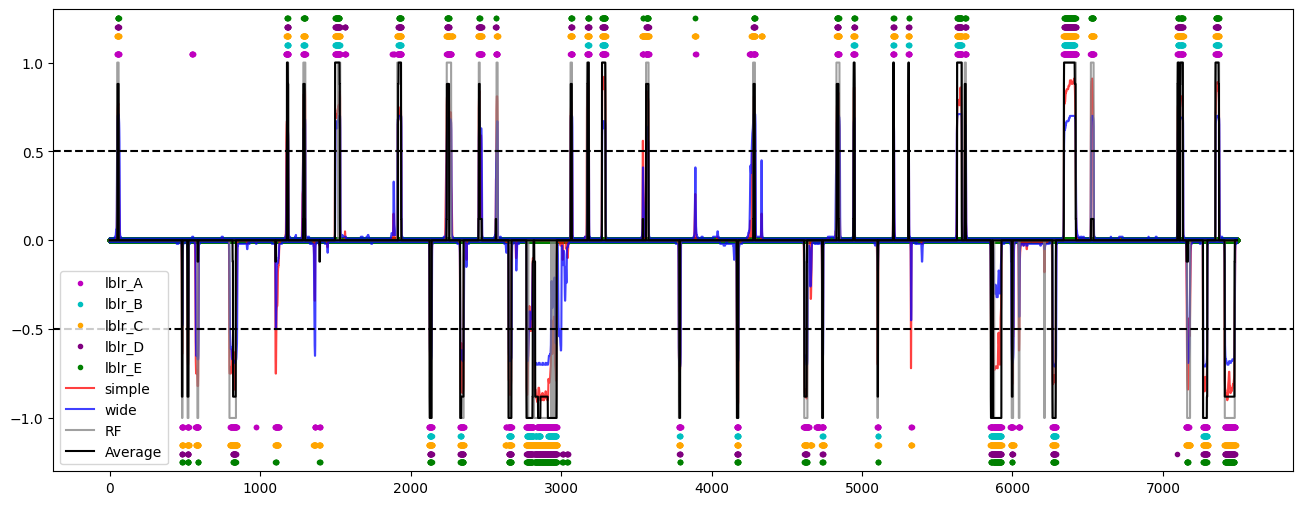

In [35]:
# Lets plot the timeline to see the performance of the model

plt.figure(figsize = (16, 6))

plt.plot(labels_A["Left"] * 1.05, ".", color = "m", label = "lblr_A")
plt.plot(labels_A["Right"] * -1.05, ".", color = "m")

plt.plot(labels_B["Left"] * 1.10, ".", color = "c", label = "lblr_B")
plt.plot(labels_B["Right"] * -1.10, ".", color = "c")

plt.plot(labels_C["Left"] * 1.15, ".", color = "orange", label = "lblr_C")
plt.plot(labels_C["Right"] * -1.15, ".", color = "orange")

plt.plot(labels_D["Left"] * 1.20, ".", color = "purple", label = "lblr_D")
plt.plot(labels_D["Right"] * -1.20, ".", color = "purple")

plt.plot(labels_E["Left"] * 1.25, ".", color = "g", label = "lblr_E")
plt.plot(labels_E["Right"] * -1.25, ".", color = "g")

plt.plot(autolabels_simple["Left"], color = "r", alpha = 0.75, label = "simple")
plt.plot(autolabels_simple["Right"] * -1, color = "r", alpha = 0.75)

plt.plot(autolabels_wide["Left"], color = "b", alpha = 0.75, label = "wide")
plt.plot(autolabels_wide["Right"] * -1, color = "b", alpha = 0.75)

plt.plot(autolabels_RF["Left"], color = "gray", alpha = 0.75, label = "RF")
plt.plot(autolabels_RF["Right"] * -1, color = "gray", alpha = 0.75)

plt.plot(transformed_avrg_example["Left"], color = "black", label = "Average")
plt.plot(transformed_avrg_example["Right"] * -1, color = "black")

# Zoom in on the labels and the minima of the distances and angles
plt.ylim((-1.3, 1.3))
plt.axhline(y=0.5, color='black', linestyle='--')
plt.axhline(y=-0.5, color='black', linestyle='--')

plt.legend()
plt.show()

In [36]:
# Define a function that allows us to visualize the labels together with the video
import cv2
from moviepy.editor import VideoFileClip
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

def process_frame(frame, frame_number):
    
    move = False
    leave = False

    # Plot using Matplotlib with Agg backend
    fig, ax = plt.subplots(figsize=(6, 4))
    
    ax.plot(labels_A["Left"] * 1.05, ".", color = "m", label = "lblr_A")
    ax.plot(labels_A["Right"] * -1.05, ".", color = "m")
    
    ax.plot(labels_B["Left"] * 1.10, ".", color = "c", label = "lblr_B")
    ax.plot(labels_B["Right"] * -1.10, ".", color = "c")
    
    ax.plot(labels_C["Left"] * 1.15, ".", color = "orange", label = "lblr_C")
    ax.plot(labels_C["Right"] * -1.15, ".", color = "orange")
    
    ax.plot(labels_D["Left"] * 1.20, ".", color = "purple", label = "lblr_D")
    ax.plot(labels_D["Right"] * -1.20, ".", color = "purple")
    
    ax.plot(labels_E["Left"] * 1.25, ".", color = "g", label = "lblr_E")
    ax.plot(labels_E["Right"] * -1.25, ".", color = "g")
    
    ax.plot(autolabels_simple["Left"], color = "r", alpha = 0.75, label = "simple")
    ax.plot(autolabels_simple["Right"] * -1, color = "r", alpha = 0.75)
    
    ax.plot(autolabels_wide["Left"], color = "b", alpha = 0.75, label = "wide")
    ax.plot(autolabels_wide["Right"] * -1, color = "b", alpha = 0.75)
    
    ax.plot(autolabels_RF["Left"], color = "gray", alpha = 0.75, label = "RF")
    ax.plot(autolabels_RF["Right"] * -1, color = "gray", alpha = 0.75)
    
    ax.plot(transformed_avrg_example["Left"], color = "black", label = "Average")
    ax.plot(transformed_avrg_example["Right"] * -1, color = "black")
        
    ax.set_xlim(frame_number-5, frame_number+5)
    ax.set_ylim(-1.3, 1.3)
    ax.axvline(x=frame_number, color='black', linestyle='--')
    ax.axhline(y=0.5, color='black', linestyle='--')
    ax.axhline(y=-0.5, color='black', linestyle='--')
    
    ax.set_title(f'Plot for Frame {frame_number}')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.grid=True

    # Save the plot as an image in memory
    plot_img_path = 'models\example\plot_img.png'
    canvas = FigureCanvas(fig)
    canvas.print_png(plot_img_path)
    
    # Load the saved plot image
    plot_img = cv2.imread(plot_img_path)
    
    # Resize the plot image to match the height of the frame
    plot_img = cv2.resize(plot_img, (frame.shape[1], frame.shape[0]))
    
    # Combine the frame and plot images horizontally
    combined_img = np.concatenate((frame, plot_img), axis=1)

    # Display the combined image
    cv2.imshow("Frame with Plot", combined_img)

    # Wait for a keystroke
    key = cv2.waitKey(0)
    
    if key == ord('6'):
        move = 1
    if key == ord('4'):
        move = -1
    if key == ord('9'):
        move = 5
    if key == ord('7'):
        move = -5
    if key == ord('3'):
        move = 50
    if key == ord('1'):
        move = -50
    if key == ord('q'):
        leave = True
    
    return move, leave

def visualize_video_frames(video_path):
    
    video = VideoFileClip(video_path)
    
    frame_generator = video.iter_frames()
    frame_list = list(frame_generator) # This takes a while
    
    # Switch Matplotlib backend to Agg temporarily
    original_backend = plt.get_backend()
    plt.switch_backend('Agg')
    
    current_frame = 0 # Starting point of the video
    leave = False
    
    while current_frame < len(frame_list) and not leave:
              
        frame = frame_list[current_frame] # The frame we are labeling
        
        # Process the current frames
        move, leave = process_frame(frame, current_frame)
        
        if move: # Move some frames
            if 0 < (current_frame + move) < len(frame_list):
                current_frame += move
                
    
    # Revert Matplotlib backend to the original backend
    plt.switch_backend(original_backend)
    
    # Close the OpenCV windows
    cv2.destroyAllWindows()


In [37]:
visualize_video_frames(video_path)